## Pricing strategy in adversarial environment

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define the adversarial pricing environment

In [2]:
# Environment for Pricing Strategy
class PricingEnvironment:
    def __init__(self, price_sequence, buy_probability_functions, cost):
        self.price_sequence = price_sequence
        self.buy_probability_functions = buy_probability_functions
        self.cost = cost
        self.t = 0

    def round(self, p_t, n_t): # p_t is price, n_t is the number of people who see the product. t is the round
        d_t = np.random.binomial(n_t, self.buy_probability_functions[self.t](p_t))
        r_t = (p_t - self.cost)*d_t # r_t is the profit
        self.t += 1
        return d_t, r_t

Define the EXP3 agent

In [3]:
# Multi-Armed Bandit for Pricing
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

Define the probability with which an user buys for every price

In [4]:
# Function to simulate buy probability as a function of price
def buy_probability_function(price, t):
    base_prob = np.clip(1 - price, 0, 1)  # simple linear decreasing function of price
    # Add high-frequency components for non-stationarity
    time_variation = 0.5 + 0.5 * np.sin(0.1 * t) + 0.5 * np.sin(0.5 * t)
    return np.clip(base_prob * time_variation, 0, 1)

Define the baseline

In [5]:
# Get the best arm in hindsight as the clairvoyant arm
def get_clairvoyant_arm(n_customers, price_sequence, buy_probability_functions, T, cost):
    
    reward_function = lambda price, n_sales: (price-cost)*n_sales
    total_losses = []
    for price in price_sequence:
        losses_price = []
        for t in range(T):
            # massimo profitto specifico per questo giorno
            profit_curve = reward_function(price_sequence, n_customers*buy_probability_functions[t](price_sequence))
            optimal_price_index = np.argmax(profit_curve)
            optimal_profit = profit_curve[optimal_price_index]

            # profitto del prezzo selezionato
            conversion_probability = buy_probability_functions[t](price)
            n_sales = n_customers*conversion_probability
            profit = (price - cost)*n_sales
            
            # loss giornaliera
            loss = optimal_profit - profit
            losses_price.append(loss)
        
        total_loss_price = np.sum(losses_price)
        total_losses.append(total_loss_price)
    
    clairvoyant_arm_index = np.argmin(total_losses)
    clairvoyant_arm = price_sequence[clairvoyant_arm_index]

    return clairvoyant_arm

Run the pricing algorithm

T = 200 days

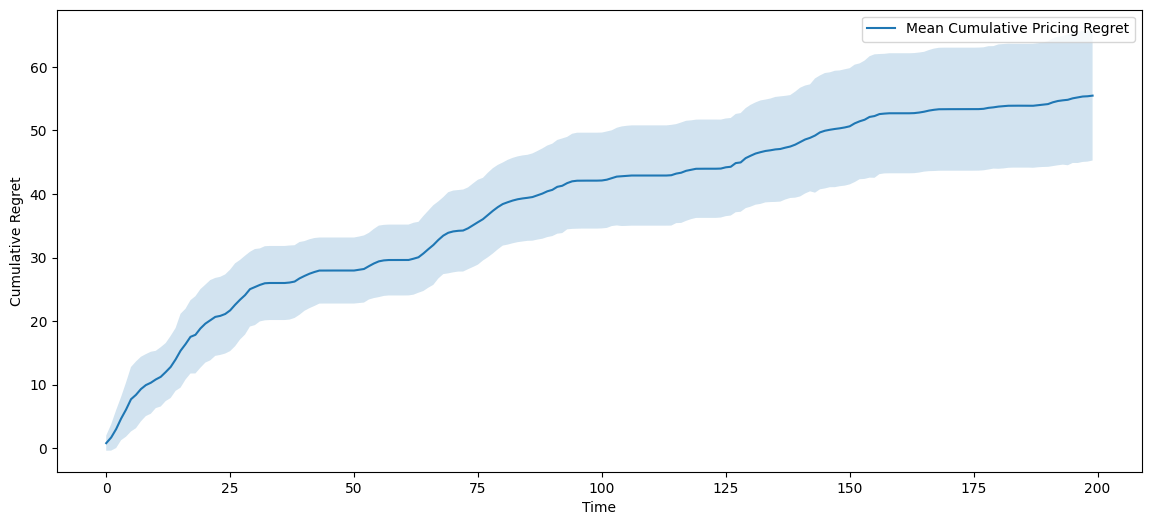

Price chosen by the clairvoyant in hindsight: 0.5555555555555556
Mean Final Pricing Regret: 55.46888888888894 ± 10.212103445917668


In [6]:
# Set parameters
T = 200  # days
K = 10  # discrete prices
cost_per_unit = 0.1 # cost per unit sold
n_customers = 10 # number of customers seing the price
num_iterations = 50  # number of iterations for different seeds

# Initialize arrays to store regrets
pricing_regret_list = []

# Iterate over different seeds
for iteration in range(num_iterations):
    # Set seed for reproducibility
    np.random.seed(iteration)

    # Generate highly non-stationary buy probability functions
    price_sequence = np.linspace(0, 1, K)
    buy_probability_functions = [lambda p, t=t: buy_probability_function(p, t) for t in range(T)]

    # Initialize environments
    pricing_env = PricingEnvironment(price_sequence, buy_probability_functions, cost_per_unit)

    # Initialize agents
    learning_rate = np.sqrt(np.log(K) / (K * T))
    pricing_agent = EXP3Agent(K, learning_rate)

    # Compute clairvoyant arm
    clairvoyant_arm = get_clairvoyant_arm(n_customers, price_sequence, buy_probability_functions, T, cost_per_unit)

    # Run the pricing algorithm
    clairvoyant_losses = []
    pricing_losses = []
    for t in range(T):
        # Pricing step
        price_arm = pricing_agent.pull_arm()
        price = price_sequence[price_arm]
        d_t, r_t = pricing_env.round(price, n_customers)

        # Compute the optimal profit for this time step
        optimal_profit = max((price_sequence - cost_per_unit) * n_customers * buy_probability_functions[t](price_sequence))

        # Calculate the clayrvoiant loss
        clairvoyant_profit = (clairvoyant_arm - cost_per_unit) * d_t
        clairvoyant_loss = optimal_profit - clairvoyant_profit
        clairvoyant_losses.append(clairvoyant_loss)

        # Calculate the instantaneous loss
        agent_loss = optimal_profit - r_t
        pricing_losses.append(agent_loss)

        # Update the agent
        pricing_agent.update(agent_loss)


    cumulative_clairvoyant_losses = np.cumsum(clairvoyant_losses)
    cumulative_pricing_losses = np.cumsum(pricing_losses)

    # Compute cumulative regret
    cumulative_pricing_regret = cumulative_pricing_losses - cumulative_clairvoyant_losses

    # Store regrets
    pricing_regret_list.append(cumulative_pricing_regret)

# Convert lists to arrays for easier manipulation
pricing_regret_array = np.array(pricing_regret_list)

# Compute mean and standard deviation of cumulative regret
mean_pricing_regret = np.mean(pricing_regret_array, axis=0)
std_pricing_regret = np.std(pricing_regret_array, axis=0)

# Plot cumulative regret
plt.figure(figsize=(14, 6))
plt.plot(mean_pricing_regret, label='Mean Cumulative Pricing Regret')
plt.fill_between(range(T), mean_pricing_regret - std_pricing_regret, mean_pricing_regret + std_pricing_regret, alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.show()

print(f'Price chosen by the clairvoyant in hindsight: {clairvoyant_arm}')
print(f'Mean Final Pricing Regret: {mean_pricing_regret[-1]} ± {std_pricing_regret[-1]}')

T = 10000 days

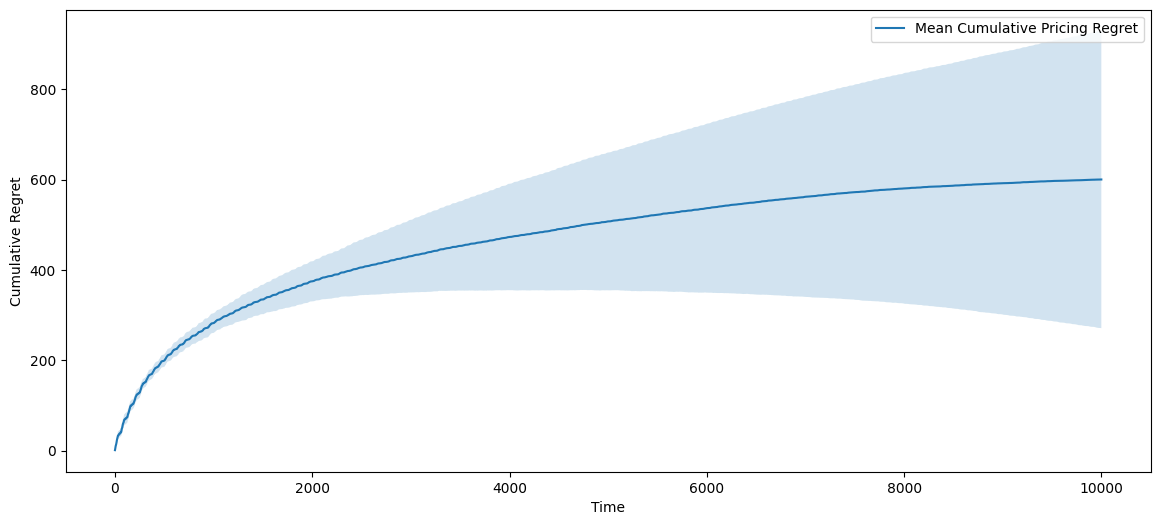

Price chosen by the clairvoyant in hindsight: 0.5555555555555556
Mean Final Pricing Regret: 600.2133333333339 ± 329.40828120048315


In [7]:
# Set parameters
T = 10000  # days
K = 10  # discrete prices
cost_per_unit = 0.1 # cost per unit sold
n_customers = 10 # number of customers seing the price
num_iterations = 50  # number of iterations for different seeds

# Initialize arrays to store regrets
pricing_regret_list = []

# Iterate over different seeds
for iteration in range(num_iterations):
    # Set seed for reproducibility
    np.random.seed(iteration)

    # Generate highly non-stationary buy probability functions
    price_sequence = np.linspace(0, 1, K)
    buy_probability_functions = [lambda p, t=t: buy_probability_function(p, t) for t in range(T)]

    # Initialize environments
    pricing_env = PricingEnvironment(price_sequence, buy_probability_functions, cost_per_unit)

    # Initialize agents
    learning_rate = np.sqrt(np.log(K) / (K * T))
    pricing_agent = EXP3Agent(K, learning_rate)

    # Compute clairvoyant arm
    clairvoyant_arm = get_clairvoyant_arm(n_customers, price_sequence, buy_probability_functions, T, cost_per_unit)

    # Run the pricing algorithm
    clairvoyant_losses = []
    pricing_losses = []
    for t in range(T):
        # Pricing step
        price_arm = pricing_agent.pull_arm()
        price = price_sequence[price_arm]
        d_t, r_t = pricing_env.round(price, n_customers)

        # Compute the optimal profit for this time step
        optimal_profit = max((price_sequence - cost_per_unit) * n_customers * buy_probability_functions[t](price_sequence))

        # Calculate the clayrvoiant loss
        clairvoyant_profit = (clairvoyant_arm - cost_per_unit) * d_t
        clairvoyant_loss = optimal_profit - clairvoyant_profit
        clairvoyant_losses.append(clairvoyant_loss)

        # Calculate the instantaneous loss
        agent_loss = optimal_profit - r_t
        pricing_losses.append(agent_loss)

        # Update the agent
        pricing_agent.update(agent_loss)


    cumulative_clairvoyant_losses = np.cumsum(clairvoyant_losses)
    cumulative_pricing_losses = np.cumsum(pricing_losses)

    # Compute cumulative regret
    cumulative_pricing_regret = cumulative_pricing_losses - cumulative_clairvoyant_losses

    # Store regrets
    pricing_regret_list.append(cumulative_pricing_regret)

# Convert lists to arrays for easier manipulation
pricing_regret_array = np.array(pricing_regret_list)

# Compute mean and standard deviation of cumulative regret
mean_pricing_regret = np.mean(pricing_regret_array, axis=0)
std_pricing_regret = np.std(pricing_regret_array, axis=0)

# Plot cumulative regret
plt.figure(figsize=(14, 6))
plt.plot(mean_pricing_regret, label='Mean Cumulative Pricing Regret')
plt.fill_between(range(T), mean_pricing_regret - std_pricing_regret, mean_pricing_regret + std_pricing_regret, alpha=0.2)
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.legend()

plt.show()

print(f'Price chosen by the clairvoyant in hindsight: {clairvoyant_arm}')
print(f'Mean Final Pricing Regret: {mean_pricing_regret[-1]} ± {std_pricing_regret[-1]}')